Using device: cpu
Loaded 8000 samples from data/captcha_images/train
Loaded 2000 samples from data/captcha_images/val
Model initialized with 5431910 parameters
Starting training...

Epoch 1/50
--------------------------------------------------
Batch 0/125, Loss: 27.6270
Batch 100/125, Loss: 3.7905
True: 'LH8ZG' | Pred: 'EY' | Match: False
True: '1IIIO' | Pred: 'EY' | Match: False
True: 'Y9TF' | Pred: 'EY' | Match: False
Train Loss: 4.3275
Val Loss: 3.8257
Val Accuracy: 0.0000
Model saved!

Epoch 2/50
--------------------------------------------------
Batch 0/125, Loss: 3.7633
Batch 100/125, Loss: 3.7845
True: 'LH8ZG' | Pred: 'A' | Match: False
True: '1IIIO' | Pred: 'A' | Match: False
True: 'Y9TF' | Pred: 'A' | Match: False
Train Loss: 3.8058
Val Loss: 3.8046
Val Accuracy: 0.0000
Model saved!

Epoch 3/50
--------------------------------------------------
Batch 0/125, Loss: 3.8753
Batch 100/125, Loss: 3.7863
True: 'LH8ZG' | Pred: 'L' | Match: False
True: '1IIIO' | Pred: 'L' | Match: Fals

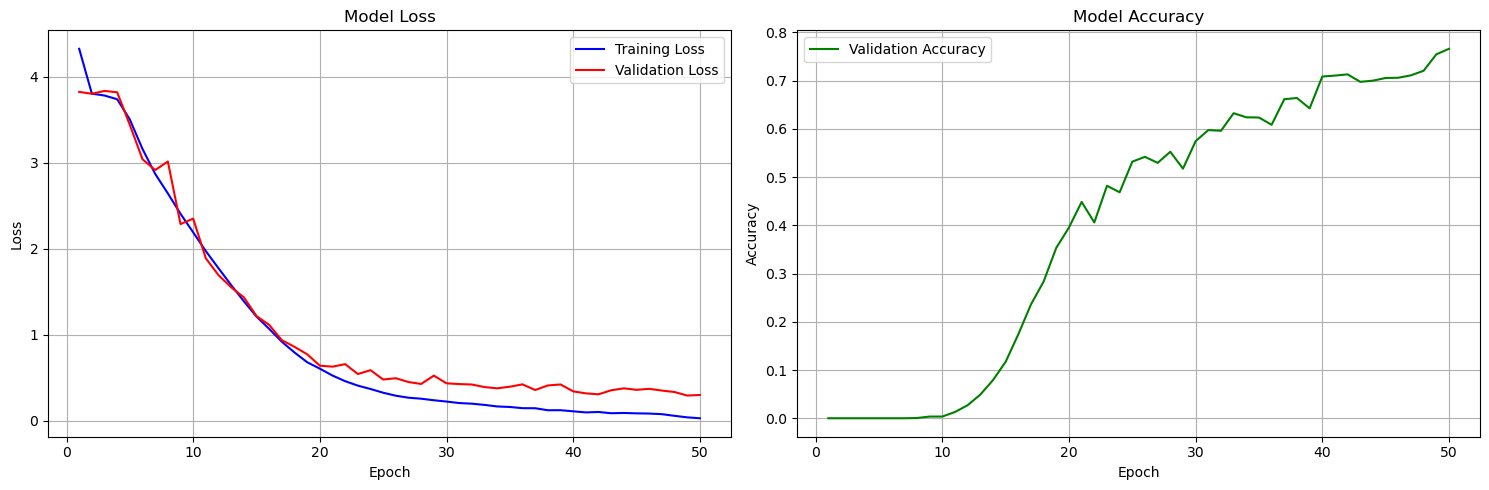

Training completed!


In [3]:
# Custom CRNN-based CAPTCHA Recognition System
# Enhanced version with custom dataset integration and improved architecture

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import string
from captcha.image import ImageCaptcha

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enhanced Configuration Class
class CaptchaConfig:
    def __init__(self):
        # Dataset parameters
        self.img_height = 60
        self.img_width = 160
        self.max_text_length = 5
        self.vocabulary = string.ascii_uppercase + "0123456789"
        self.vocab_size = len(self.vocabulary) + 1  # +1 for CTC blank
        
        # Model architecture parameters
        self.cnn_output_height = 1
        self.cnn_output_width = 40
        self.rnn_hidden_size = 256
        self.rnn_layers = 2
        self.dropout_rate = 0.3
        
        # Training parameters
        self.batch_size = 64
        self.learning_rate = 0.001
        self.num_epochs = 50
        self.weight_decay = 1e-4
        
        # Data paths
        self.data_dir = "data/captcha_images"
        self.model_save_path = "models/captcha_crnn.pth"

config = CaptchaConfig()

# Enhanced Dataset Generator with More Variations
class AdvancedCaptchaGenerator:
    def __init__(self, config):
        self.config = config
        self.image_captcha = ImageCaptcha(
            width=config.img_width, 
            height=config.img_height,
            fonts=[
                # Add variety in fonts if available
            ]
        )
    
    def generate_dataset(self, num_samples=8000, output_dir=None, split_ratio=0.8):
        """Generate training and validation datasets"""
        if output_dir is None:
            output_dir = self.config.data_dir
            
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(f"{output_dir}/train", exist_ok=True)
        os.makedirs(f"{output_dir}/val", exist_ok=True)
        
        train_samples = int(num_samples * split_ratio)
        
        for i in range(num_samples):
            # Generate random text
            text_length = random.randint(4, self.config.max_text_length)
            text = ''.join(random.choices(self.config.vocabulary, k=text_length))
            
            # Create filename with text and unique identifier
            filename = f"{text}_{i:05d}.png"
            
            # Determine split
            if i < train_samples:
                filepath = os.path.join(output_dir, "train", filename)
            else:
                filepath = os.path.join(output_dir, "val", filename)
            
            # Generate and save image
            self.image_captcha.write(text, filepath)
        
        print(f"Generated {train_samples} training and {num_samples - train_samples} validation samples")

# Enhanced Custom Dataset Class
class CustomCaptchaDataset(Dataset):
    def __init__(self, data_dir, config, transform=None, is_training=True):
        self.data_dir = data_dir
        self.config = config
        self.transform = transform
        self.is_training = is_training
        
        # Load image filenames
        self.image_paths = []
        self.labels = []
        
        for filename in os.listdir(data_dir):
            if filename.endswith('.png'):
                # Extract label from filename (text before first underscore)
                label = filename.split('_')[0]
                if len(label) <= config.max_text_length:
                    self.image_paths.append(os.path.join(data_dir, filename))
                    self.labels.append(label)
        
        # Create character to index mapping
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(config.vocabulary)}
        self.char_to_idx['<blank>'] = 0  # CTC blank token
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.idx_to_char[0] = '<blank>'  # Ensure blank token mapping
        
        print(f"Loaded {len(self.image_paths)} samples from {data_dir}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def encode_text(self, text):
        """Convert text to sequence of indices"""
        return [self.char_to_idx[char] for char in text]
    
    def decode_prediction(self, indices):
        """Convert sequence of indices back to text using CTC decoding"""
        chars = []
        prev_idx = -1
        for idx in indices:
            # CTC decoding: skip blanks (0) and repeated characters
            if idx != 0 and idx != prev_idx:
                if idx in self.idx_to_char and idx != 0:
                    chars.append(self.idx_to_char[idx])
            prev_idx = idx
        return ''.join(chars)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Encode label
        label = self.labels[idx]
        encoded_label = self.encode_text(label)
        
        return image, torch.tensor(encoded_label, dtype=torch.long), len(encoded_label)

# Enhanced CNN Feature Extractor with ResNet-inspired blocks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class EnhancedCNNExtractor(nn.Module):
    def __init__(self, config):
        super(EnhancedCNNExtractor, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        
        # Adaptive pooling to ensure consistent output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((config.cnn_output_height, config.cnn_output_width))
        self.dropout = nn.Dropout(config.dropout_rate)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        
        return x

# Enhanced Bidirectional LSTM with Attention
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, config):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            bidirectional=True,
            dropout=config.dropout_rate if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(config.dropout_rate)
        
    def forward(self, x):
        # x shape: (batch, seq_len, feature_size)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size * 2)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        return lstm_out

# Complete CRNN Model
class ImprovedCRNN(nn.Module):
    def __init__(self, config):
        super(ImprovedCRNN, self).__init__()
        self.config = config
        
        # CNN feature extractor
        self.cnn = EnhancedCNNExtractor(config)
        
        # Calculate RNN input size
        rnn_input_size = 256  # Output channels from CNN
        
        # RNN sequence processor
        self.rnn = AttentionLSTM(
            rnn_input_size, 
            config.rnn_hidden_size, 
            config.rnn_layers, 
            config
        )
        
        # Output layer
        self.classifier = nn.Linear(config.rnn_hidden_size * 2, config.vocab_size)
        
    def forward(self, x):
        # CNN feature extraction
        cnn_features = self.cnn(x)  # (batch, 256, 1, 40)
        
        # Reshape for RNN: (batch, seq_len, feature_size)
        batch_size, channels, height, width = cnn_features.size()
        cnn_features = cnn_features.permute(0, 3, 1, 2)  # (batch, width, channels, height)
        cnn_features = cnn_features.view(batch_size, width, channels * height)
        
        # RNN processing
        rnn_output = self.rnn(cnn_features)  # (batch, seq_len, hidden_size * 2)
        
        # Classification
        output = self.classifier(rnn_output)  # (batch, seq_len, vocab_size)
        
        # For CTC loss, we need (seq_len, batch, vocab_size)
        output = output.permute(1, 0, 2)
        
        return F.log_softmax(output, dim=2)

# Training and Evaluation Functions
class CaptchaTrainer:
    def __init__(self, model, config, train_loader, val_loader):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Loss and optimizer
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        self.optimizer = optim.AdamW(
            model.parameters(), 
            lr=config.learning_rate, 
            weight_decay=config.weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5
        )
        
        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (images, labels, label_lengths) in enumerate(self.train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = self.model(images)
            
            # Prepare for CTC loss
            input_lengths = torch.full(
                size=(images.size(0),), 
                fill_value=outputs.size(0), 
                dtype=torch.long
            )
            
            # Flatten labels for CTC
            flattened_labels = []
            for i in range(len(labels)):
                flattened_labels.extend(labels[i][:label_lengths[i]].tolist())
            flattened_labels = torch.tensor(flattened_labels, dtype=torch.long).to(device)
            
            # Calculate loss
            loss = self.criterion(outputs, flattened_labels, input_lengths, label_lengths)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}')
        
        return total_loss / num_batches
    
    def validate(self):
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        with torch.no_grad():
            for batch_idx, (images, labels, label_lengths) in enumerate(self.val_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = self.model(images)
                
                # Calculate loss
                input_lengths = torch.full(
                    size=(images.size(0),), 
                    fill_value=outputs.size(0), 
                    dtype=torch.long
                )
                
                flattened_labels = []
                for i in range(len(labels)):
                    flattened_labels.extend(labels[i][:label_lengths[i]].tolist())
                flattened_labels = torch.tensor(flattened_labels, dtype=torch.long).to(device)
                
                loss = self.criterion(outputs, flattened_labels, input_lengths, label_lengths)
                total_loss += loss.item()
                
                # Calculate accuracy with better CTC decoding
                predictions = torch.argmax(outputs, dim=2)  # (seq_len, batch)
                predictions = predictions.permute(1, 0)  # (batch, seq_len)
                
                for i in range(predictions.size(0)):
                    pred_indices = predictions[i].cpu().numpy()
                    pred_text = self.val_loader.dataset.decode_prediction(pred_indices)
                    
                    # Get true text
                    true_indices = labels[i][:label_lengths[i]].cpu().numpy()
                    true_text = ''.join([
                        self.val_loader.dataset.idx_to_char[idx] 
                        for idx in true_indices 
                        if idx in self.val_loader.dataset.idx_to_char and idx != 0
                    ])
                    
                    if pred_text == true_text:
                        correct_predictions += 1
                    total_predictions += 1
                    
                    # Debug: print some examples
                    if batch_idx == 0 and i < 3:
                        print(f"True: '{true_text}' | Pred: '{pred_text}' | Match: {pred_text == true_text}")
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        return avg_loss, accuracy
    
    def train(self):
        print("Starting training...")
        os.makedirs(os.path.dirname(self.config.model_save_path), exist_ok=True)
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.config.num_epochs):
            print(f'\nEpoch {epoch+1}/{self.config.num_epochs}')
            print('-' * 50)
            
            # Train
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)
            
            # Validate
            val_loss, val_acc = self.validate()
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f}')
            print(f'Val Loss: {val_loss:.4f}')
            print(f'Val Accuracy: {val_acc:.4f}')
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_accuracy': val_acc,
                    'config': self.config
                }, self.config.model_save_path)
                print("Model saved!")
            else:
                patience_counter += 1
                
            # Early stopping
            if patience_counter >= 10:
                print("Early stopping triggered!")
                break
        
        self.plot_training_history()
    
    def plot_training_history(self):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy plot
        ax2.plot(epochs, self.val_accuracies, 'g-', label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

# Collate function for batching (moved outside main to avoid pickle issues)
def collate_fn(batch):
    images, labels, lengths = zip(*batch)
    images = torch.stack(images)
    
    # Pad labels to same length
    max_length = max(lengths)
    padded_labels = torch.zeros(len(labels), max_length, dtype=torch.long)
    for i, (label, length) in enumerate(zip(labels, lengths)):
        padded_labels[i, :length] = label
    
    return images, padded_labels, torch.tensor(lengths, dtype=torch.long)

# Main execution function
def main():
    # Initialize configuration
    config = CaptchaConfig()
    
    # Generate dataset if not exists
    if not os.path.exists(f"{config.data_dir}/train"):
        print("Generating custom CAPTCHA dataset...")
        generator = AdvancedCaptchaGenerator(config)
        generator.generate_dataset(num_samples=10000)
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((config.img_height, config.img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = CustomCaptchaDataset(
        f"{config.data_dir}/train", config, transform=transform, is_training=True
    )
    val_dataset = CustomCaptchaDataset(
        f"{config.data_dir}/val", config, transform=transform, is_training=False
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, 
        num_workers=0, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, 
        num_workers=0, collate_fn=collate_fn
    )
    
    # Initialize model
    model = ImprovedCRNN(config).to(device)
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Initialize trainer and start training
    trainer = CaptchaTrainer(model, config, train_loader, val_loader)
    trainer.train()
    
    print("Training completed!")

# Inference function for testing
def test_model(model_path, test_image_path, config):
    """Test the trained model on a single image"""
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = ImprovedCRNN(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((config.img_height, config.img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(test_image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Create dummy dataset for decoding
    dummy_dataset = CustomCaptchaDataset(
        os.path.dirname(test_image_path), config, transform=None, is_training=False
    )
    
    # Inference
    with torch.no_grad():
        output = model(image_tensor)
        predictions = torch.argmax(output, dim=2).squeeze().cpu().numpy()
        predicted_text = dummy_dataset.decode_prediction(predictions)
    
    return predicted_text

if __name__ == "__main__":
    main()